# Importing Libraries

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from hyperopt import hp, tpe, fmin, Trials, space_eval
import warnings
import shap
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# Configuration

In [ ]:
#Set the number of iteration for hyperparameter optimization
N_trials = 10

#Set number of cross-validation folds
cv = 10

# Importing Data

In [273]:
Data = pd.read_csv('feature_data/features_00.csv')

# Indices = pd.read_csv('outliers_comb.csv')[:]
# Indices = Indices.iloc[:, 0].tolist()
# Unique_Indices = remove_duplicates_and_sort(Indices)

# Data = Data.drop(Unique_Indices, axis = 0)

###Check for NaN's###
if Data.isnull().any().any():
    raise ValueError("DataFrame contains at least one NaN value")

# print(Data[Data['getSegmentOrder'] == 1])

# Data = pd.read_csv(r'C:\Users\George\Desktop\Local\AML_FProject\feature_data\features_05.csv')
print('Got',len(Data),'entries')
print(int(len(Data)*0.9),'data are gonna be used for the Training (X_train_val)')

Got 2417 entries
2175 data are gonna be used for the Training (X_train_val)


# Splitting the Data into train, validation and test sets and training a Classifier to determine the importances

In [274]:

X = Data.drop(['label'], axis=1)
y = Data['label']

# #Deactivate for benchmarking
# corr_matrix = pd.DataFrame(X).corr()
# threshold = 0.8
# cols_to_drop = set()
# for i in range(len(corr_matrix.columns)):
#     for j in range(i):
#         if abs(corr_matrix.iloc[i, j]) > threshold:
#             colname = corr_matrix.columns[i]
#             cols_to_drop.add(colname)
# print(len(cols_to_drop))
# X = X.drop(columns=list(cols_to_drop))

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split the data into training and validation sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', learning_rate=0.1,
                            max_depth=8, eval_metric='logloss', n_estimators=300,
                            seed=42, use_label_encoder=False, n_jobs = -1)

start_time = time.time()
xgb_clf.fit(X_train, y_train)
end_time = time.time()

elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds \n")

y_pred_proba = xgb_clf.predict_proba(X_val)[:, 1]

accuracy = accuracy_score(y_val, y_pred_proba.round())
conf_matrix = confusion_matrix(y_val, y_pred_proba.round())
logloss = log_loss(y_val, y_pred_proba)

print('On the Validation set:\n')
print("Accuracy:", accuracy)
print("LogLoss:", logloss,)
print("Confusion matrix:", conf_matrix[0], "\n"," "*16, conf_matrix[1])


y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred_proba.round())
conf_matrix = confusion_matrix(y_test, y_pred_proba.round())
logloss = log_loss(y_test, y_pred_proba)
print('On the Test set:\n')
print("Accuracy:", accuracy)
print("LogLoss:", logloss)
print("Confusion matrix:", conf_matrix[0], "\n"," "*16, conf_matrix[1])

Elapsed time: 0.3492162227630615 seconds 

On the Validation set:

Accuracy: 0.8027522935779816
LogLoss: 0.5586161873078425
Confusion matrix: [91 20] 
                  [23 84]
On the Test set:

Accuracy: 0.8181818181818182
LogLoss: 0.4348208471697519
Confusion matrix: [97 18] 
                  [ 26 101]


# 20 most important features using **XGBoost's feature importance**

In [275]:
importances = xgb_clf.feature_importances_
sorted_indices = importances.argsort()[::-1]
top_features = X.columns[sorted_indices[:20]]

top_features_df = pd.DataFrame({'Top Features based on feature importances': top_features}, index=range(1, len(top_features) + 1))
display(top_features_df)

,Top Features based on feature importances
1,getH3R
2,getEnergyB
3,getH5B
4,getH8R
5,getAreaOfHoles
6,getNHoles
7,getSymR


# **Correlation matrix** of the most important features

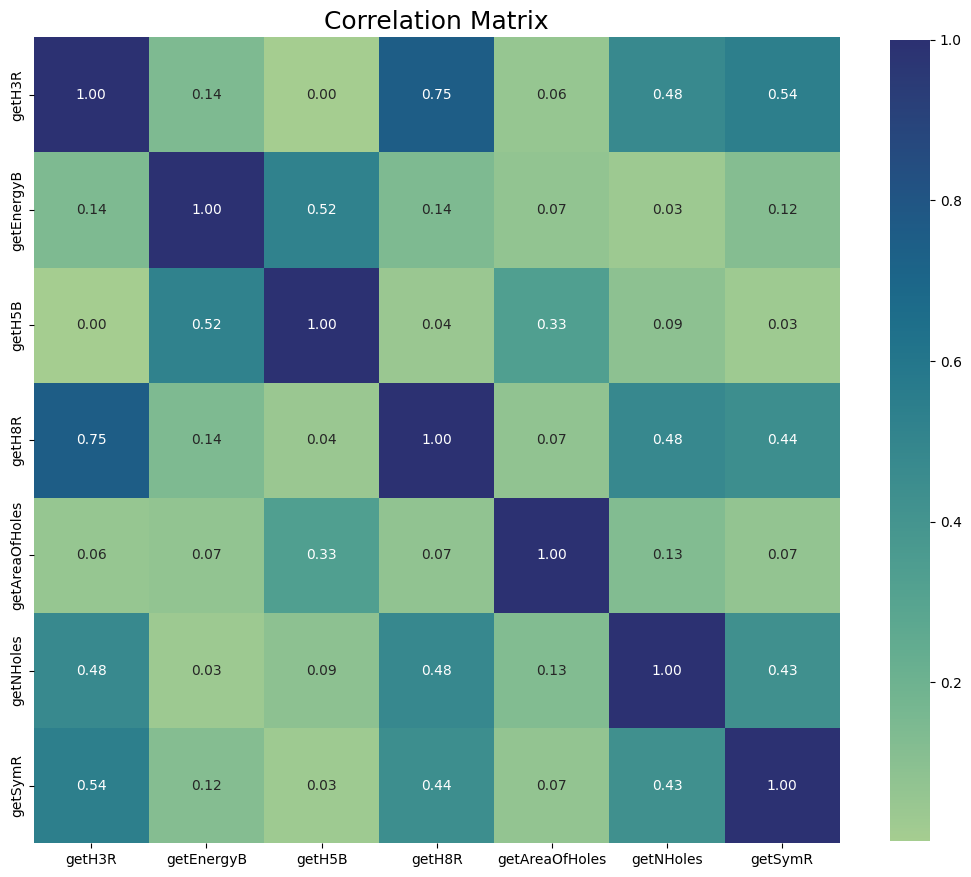

In [276]:
X_top_features = X[top_features]
correlation_matrix = X_top_features.corr()

###UNCOMMENT FOR SPEARMAN METHOD####
# correlation_matrix = X_top_features.corr(method = 'spearman')

fig, ax = plt.subplots(figsize = (13,13))
sns.heatmap(np.abs(correlation_matrix), annot = True, cmap = 'crest', square = True, fmt=".2f", cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix', fontsize = 18)
plt.show()

# 20 most important features using **Shap values** on all data

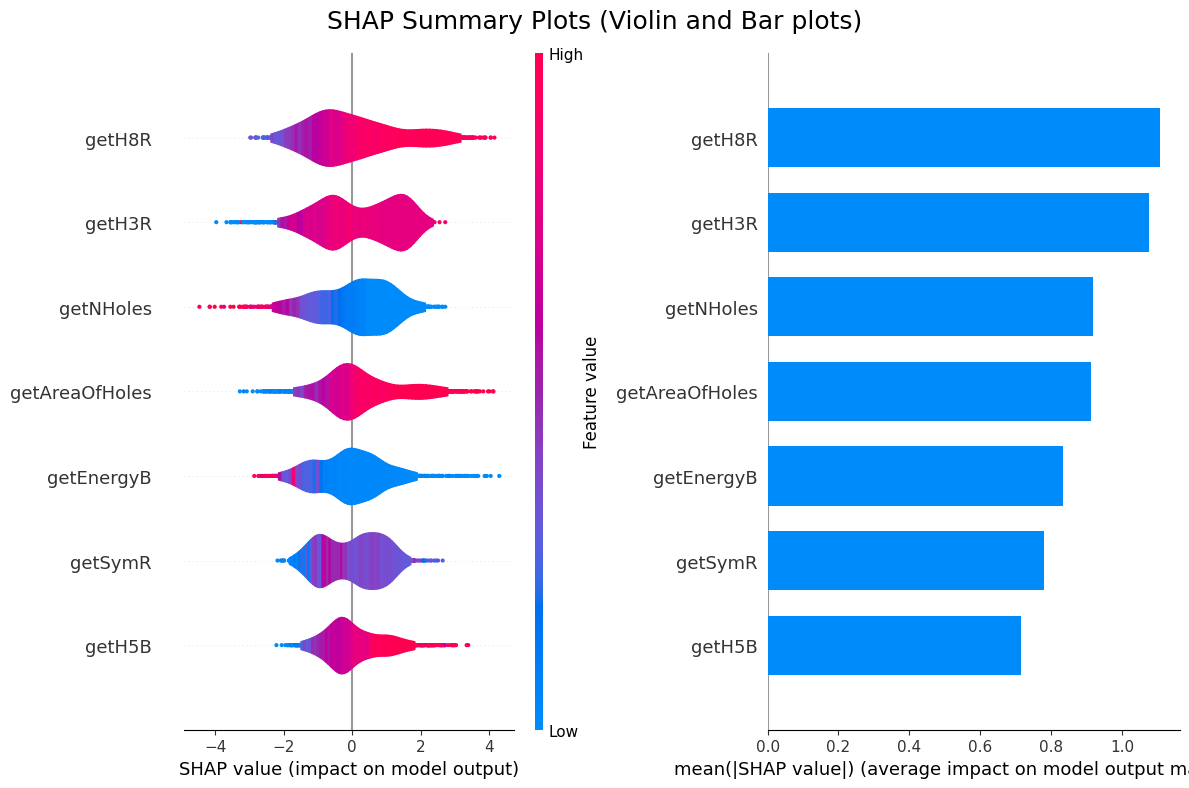

In [277]:
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_train)

fig, ax = plt.subplots(1, 2, figsize=(10, 8))

shap.summary_plot(shap_values, X_train, feature_names=X.columns, plot_type='bar', show = False, plot_size = (12, 8))
plt.sca(ax[0]) 

shap.summary_plot(shap_values, X_train, plot_type='violin', show = False, plot_size = (12, 8))
plt.sca(ax[1])
fig.suptitle('SHAP Summary Plots (Violin and Bar plots)', fontsize=18)
plt.tight_layout()
plt.show()

# **Correlation matrix** of the most important features (**SHAP**)

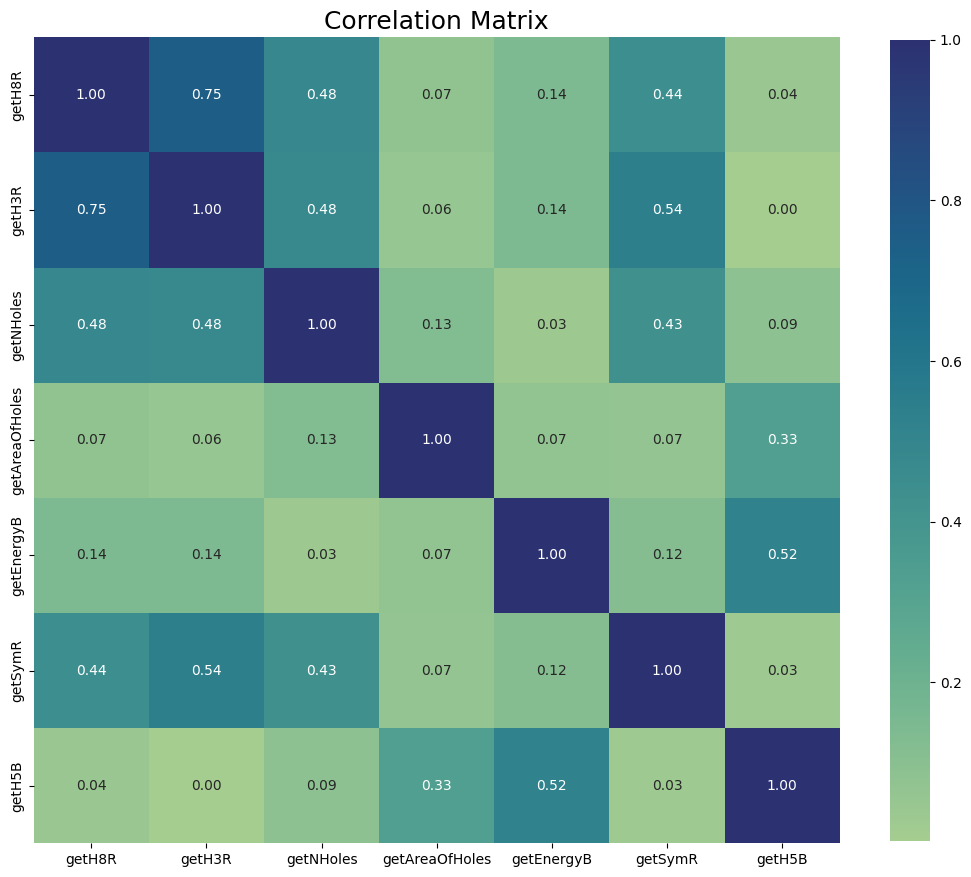

In [278]:
feature_importance = np.abs(shap_values).mean(axis=0)
top_indices_shap = np.argsort(feature_importance)[-20:][::-1]
top_features_shap = X.columns[top_indices_shap]

X_top_features_shap = X[top_features_shap]
correlation_matrix_shap = X_top_features_shap.corr()
###UNCOMMENT FOR SPEARMAN METHOD####
# correlation_matrix_shap = X_top_features_shap.corr(method = 'spearman')

fig, ax = plt.subplots(figsize = (13,13))
sns.heatmap(np.abs(correlation_matrix_shap), annot = True, cmap = 'crest', square = True, fmt=".2f", cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix', fontsize = 18)
plt.show()

# **Hyperparameter search** (**Bayes optimization**) with Cross-Validation

In [279]:
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-04), np.log(0.3)),
    'dropout': hp.loguniform('dropout', np.log(1e-08), np.log(0.5)),
    'max_depth': hp.choice('max_depth', np.arange(3, 20, dtype=int)),
    'subsample': hp.uniform('subsample', 0.0, 1.0), 
    'colsample_bytree': hp.uniform('colsample_bytree', 0.0, 1.0),
    # 'gamma': hp.loguniform('gamma', np.log(1e-8), np.log(1)),
    'n_estimators': hp.choice('n_estimators', np.arange(100, 2000, 50, dtype=int)),
    'min_child_weight': hp.loguniform('min_child_weight', np.log(1e-8), np.log(10)),
    # 'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-8), np.log(10)), 
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-8), np.log(10)),
    # 'scale_pos_weight': hp.loguniform('scale_pos_weight', np.log(1e-08), np.log(50)), 
    'lr_decay': hp.loguniform('lr_decay', np.log(1e-08), np.log(1.0))
}

def objective(params):
    model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', seed=42, use_label_encoder=False, **params, n_jobs = -1)
    scores = cross_val_score(model, X_train_val, y_train_val, cv=cv, scoring='neg_log_loss')
    return -np.mean(scores)

trials = Trials()
start_time = time.time()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals = N_trials, trials=trials)
end_time = time.time()

best_params = space_eval(space, best)
print("Best Hyperparameters:", best_params)

elapsed_time = end_time - start_time
print("Elapsed time of Bayesian optimization:", elapsed_time, "seconds \n")

100%|██████████| 10/10 [05:38<00:00, 33.84s/trial, best loss: 0.40707653416623923]
Best Hyperparameters: {'colsample_bytree': 0.8760077316014714, 'dropout': 0.00013408334886987126, 'learning_rate': 0.01358537245011398, 'lr_decay': 0.08674150155320987, 'max_depth': 17, 'min_child_weight': 0.00010626873766322722, 'n_estimators': 300, 'reg_lambda': 0.0019076872229364691, 'subsample': 0.20343073957495306}
Elapsed time of Bayesian optimization: 338.39025020599365 seconds 



# Training the Classifier with the best hyperparameters with **cross validation** (multiple times)

In [280]:
from sklearn.model_selection import KFold

best_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, **best_params, n_jobs=-1)

kf = KFold(n_splits=cv, shuffle=True, random_state=42)

val_logloss_scores = []
val_accuracy_scores = []

start_time = time.time()

for train_index, val_index in kf.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]
    
    best_model.fit(X_train, y_train)
    
    y_pred_proba = best_model.predict_proba(X_val)[:, 1]
    
    val_logloss = log_loss(y_val, y_pred_proba)
    val_accuracy = accuracy_score(y_val, y_pred_proba.round())

    val_logloss_scores.append(val_logloss)
    val_accuracy_scores.append(val_accuracy)

end_time = time.time()

mean_logloss = np.mean(val_logloss_scores)
std_logloss = np.std(val_logloss_scores, ddof = 1)/np.sqrt(len(val_logloss_scores))
mean_accuracy = np.mean(val_accuracy_scores)
std_accuracy = np.std(val_accuracy_scores, ddof = 1)/np.sqrt(len(val_accuracy_scores))

print("Mean and Error on the Mean of the Accuracy from Cross-Validation:", mean_accuracy, '+\-', std_accuracy)
print("Mean and Error on the Mean of LogLoss from Cross-Validation:", mean_logloss, '+\-', std_logloss)

elapsed_time = end_time - start_time
print("Elapsed time:", elapsed_time, "seconds \n")

Mean and Error on the Mean of the Accuracy from Cross-Validation: 0.8363357713609266 +\- 0.008782747967943344
Mean and Error on the Mean of LogLoss from Cross-Validation: 0.4028838030529293 +\- 0.015557017812736837
Elapsed time: 7.817022800445557 seconds 



# Histograms of Logloss and Accuracy on the **Validation** set

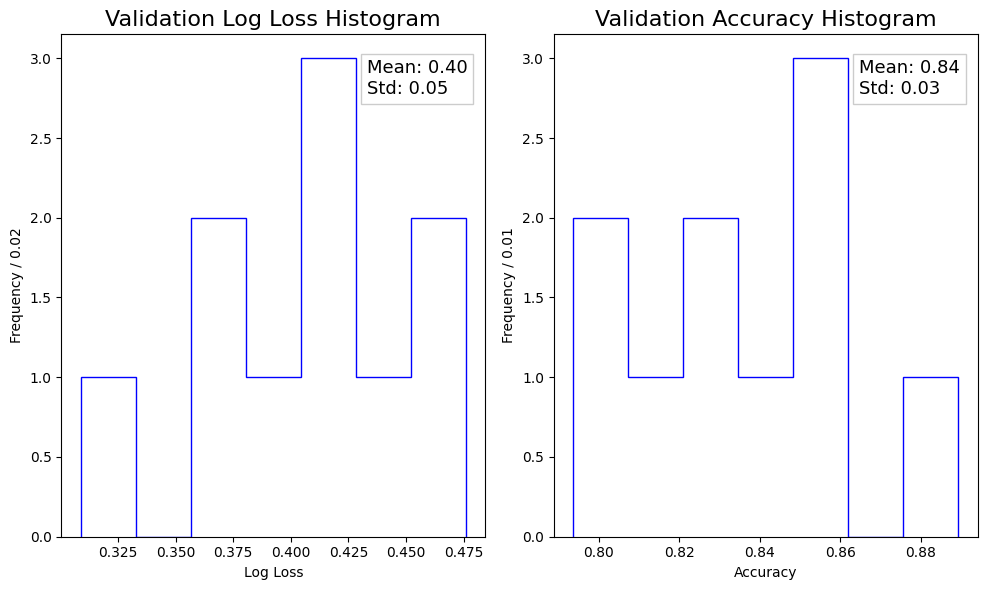

In [281]:
num_bins = 7

bin_width_accuracy = (np.max(val_accuracy_scores) - np.min(val_accuracy_scores)) / num_bins
bin_width_logloss = (np.max(val_logloss_scores) - np.min(val_logloss_scores)) / num_bins

fig, ax = plt.subplots(1, 2, figsize=(10, 6))

ax[0].hist(val_logloss_scores, bins=num_bins, histtype = 'step', color = 'b')
ax[0].set_xlabel('Log Loss')
ax[0].set_ylabel(f'Frequency / {bin_width_logloss:.2f}')
ax[0].set_title('Validation Log Loss Histogram', fontsize = 16)
ax[0].text(0.72, 0.95, f'Mean: {mean_logloss:.2f}\nStd: {std_logloss*np.sqrt(len(val_accuracy_scores)):.2f}',
transform=ax[0].transAxes, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.2), fontsize = 13)

ax[1].hist(val_accuracy_scores, bins=num_bins, histtype = 'step' ,color = 'b')
ax[1].set_xlabel('Accuracy')
ax[1].set_ylabel(f'Frequency / {bin_width_accuracy:.2f}')
ax[1].set_title('Validation Accuracy Histogram', fontsize = 16)
ax[1].text(0.72, 0.95, f'Mean: {mean_accuracy:.2f}\nStd: {std_accuracy*np.sqrt(len(val_accuracy_scores)):.2f}',
transform=ax[1].transAxes, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.2), fontsize = 13)

plt.tight_layout()
plt.show()

# Testing on the **test set**

In [282]:
best_model.fit(X_train_val, y_train_val)

y_pred_proba = best_model.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred_proba.round())
conf_matrix = confusion_matrix(y_test, y_pred_proba.round())
logloss = log_loss(y_test, y_pred_proba)

print(f'On the Test set:\n')
print("Accuracy:", accuracy)
print("LogLoss:", logloss,)
print("Confusion matrix:", conf_matrix[0], "\n"," "*16, conf_matrix[1])

On the Test set:

Accuracy: 0.8347107438016529
LogLoss: 0.34350017313755676
Confusion matrix: [96 19] 
                  [ 21 106]
